In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import artm
import copy
import re


def print_and_gather_measures(model, metrics):
    print('Sparsity Phi: ', model.get_score('SparsityPhiScore').value)
    metrics.append(model.get_score('SparsityPhiScore').value)

    print('Sparsity Theta: ', model.get_score('SparsityThetaScore').value)
    metrics.append(model.get_score('SparsityThetaScore').value)

    print('Kernel contrast: ', model.get_score('TopicKernelScore').average_kernel_contrast)
    metrics.append(model.get_score('TopicKernelScore').average_kernel_contrast)

    print('Kernel purity: ', model.get_score('TopicKernelScore').average_kernel_purity)
    metrics.append(model.get_score('TopicKernelScore').average_kernel_purity)

    print('PerplexityScore: ', model.get_score('PerplexityScore').value)
    metrics.append(model.get_score('PerplexityScore').value)

    
def get_clustering(model, topics):
    phi_matrix = copy.deepcopy(model.phi_)
    pattern = '\(\'@default_class\', \'(.*?)\'\)'
    cleaned_index = [re.search(pattern, str(x)).group(1) for x in phi_matrix.index.tolist()]
    phi_matrix.index = cleaned_index
    num_topics = len(topics)
    clustering = [list() for _ in range(num_topics)]
    for i in range(num_topics):
        current_topic = topics[i]
        phi_matrix.sort_values(by = current_topic, ascending = False, inplace = True)
        top_tokens = phi_matrix.index[phi_matrix[current_topic] > 0]
        clustering[i] = top_tokens
    return clustering

def print_clustering(clustering, topics):
    num_topics = len(topics)
    for i in range(num_topics):
        print(topics[i])
        print(clustering[i])
        print(len(clustering[i]))
        
def save_clustering(clustering, topics, filename):
    f = open(filename, "w")
    num_topics = len(topics)
    for i in range(num_topics):
        f.write(topics[i])
        f.write("\n Amount of tags in cluster: ")
        f.write(str(len(clustering[i])))
        f.write("\n")
        for j in range(len(clustering[i])):
            f.write(clustering[i][j])
            f.write(", ")
        f.write("\n")
    f.close()
    
def print_top_tags(score_tracker):
    topics = score_tracker.topic_name
    tags = score_tracker.token
    weights = score_tracker.weight
    for i in range(1, len(topics) + 1):
        if ((topics[i-1] != topics[i]) | (i == 1)):
            print(topics[i])
        print('{}: {}, '.format(tags[i], weights[i]))
        
def save_top_tags(score_tracker, filename):
    f = open(filename, "w")
    topics = score_tracker.topic_name
    tags = score_tracker.token
    weights = score_tracker.weight
    for i in range(1, len(topics)):
        if ((topics[i-1] != topics[i]) | (i == 1)):
            f.write(topics[i])
            f.write("\n")
        f.write('{}: {}; \n '.format(tags[i], weights[i]))
    f.close()

In [ ]:
batch_vectorizer = artm.BatchVectorizer(data_path='vw.tags.100.txt', data_format='vowpal_wabbit',target_folder='posts-tags-100')
dictionary = batch_vectorizer.dictionary

topic_names = ['topic_{}'.format(i) for i in range(1000)]
model_artm = artm.ARTM(topic_names = topic_names, num_processors = 4,
                       scores = [artm.PerplexityScore(name = 'PerplexityScore', dictionary = dictionary), 
                                artm.SparsityPhiScore(name = 'SparsityPhiScore'),
                                artm.SparsityThetaScore(name = 'SparsityThetaScore'), 
                                artm.TopicKernelScore(name = 'TopicKernelScore', probability_mass_threshold = 0.1),
                                artm.TopTokensScore(name = 'TopTokensScore', num_tokens = 20)],
                       regularizers = [artm.DecorrelatorPhiRegularizer(name = 'decorrelator_phi_regularizer', tau = 50000),
                                    artm.SmoothSparsePhiRegularizer(name='sparse_phi_regularizer', tau = -5)],
                       seed = 62, show_progress_bars = True)

model_artm.initialize(dictionary = dictionary)

model_artm.fit_offline(batch_vectorizer = batch_vectorizer, num_collection_passes = 15)

In [5]:
metrics_gcp_01 = []
print_and_gather_measures(model_artm, metrics_gcp_01)

Sparsity Phi:  0.999496340751648
Sparsity Theta:  0.9978924989700317
Kernel contrast:  0.9996216297149658
Kernel purity:  0.9999964237213135
PerplexityScore:  13.990248680114746


In [6]:
clustering = get_clustering(model_artm, topic_names)
#print_clustering(clustering, topic_names)
save_clustering(clustering, topic_names, "clustering_final1.txt")
#print_top_tags(model_plsa.get_score('TopTokensScore'))
save_top_tags(model_artm.get_score('TopTokensScore'), "top_tags_final1.txt")

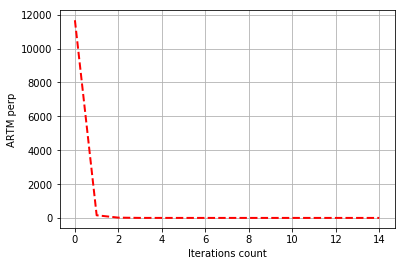

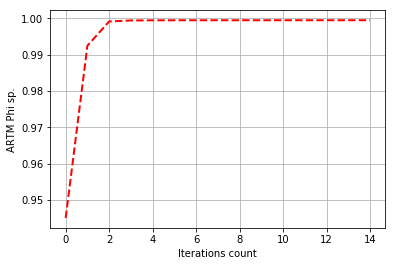

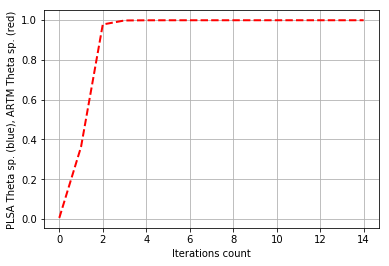

In [7]:
import matplotlib.pyplot as plt
plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['PerplexityScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM perp')
plt.grid(True)
plt.show()

plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['SparsityPhiScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('ARTM Phi sp.')
plt.grid(True)
plt.show()

plt.plot(range(model_artm.num_phi_updates), model_artm.score_tracker['SparsityThetaScore'].value, 'r--', linewidth=2)
plt.xlabel('Iterations count')
plt.ylabel('PLSA Theta sp. (blue), ARTM Theta sp. (red)')
plt.grid(True)
plt.show()

In [8]:
import pandas as pd
def save_tag_to_topic_mapping(model, filename):
    phi_matrix = copy.deepcopy(model.phi_)
    pattern = '\(\'@default_class\', \'(.*?)\'\)'
    cleaned_index = [re.search(pattern, str(x)).group(1) for x in phi_matrix.index.tolist()]
    phi_matrix.index = cleaned_index
    list = [phi_matrix.idxmax(axis=1), phi_matrix.max(axis=1)]
    df = pd.concat(list, axis=1)
    df.to_csv(filename, index = True)
    
save_tag_to_topic_mapping(model_artm, "tag2topic_final1.csv")

<>:4: DeprecationWarning: invalid escape sequence \(
